**This notebook analyses possible correlations between hateful speech on 4chan and socioeconomic factors in the USA**

In [60]:
import pandas as pd
import os

import all counts into one dataframe

In [61]:
counts_path = "./Counts"
counts_files = ["./Counts/" + p for p in filter(lambda x: ".csv" in x, os.listdir(counts_path))]

In [62]:
df = None
for f in counts_files:
    if df is None:
        df = pd.read_csv(f, index_col=0)
    else:
        df = df.append(pd.read_csv(f, index_col=0))

In [63]:
df.head()

,timestamp,content,matched_vocab
id,,,
52270200,1577401200,judge halt unconstitutional poll tax in north ...,NaN
52270201,1577401200,522702north carolina democratic attorney gener...,NaN
52270202,1577401200,522702get fucked with your incendiary title th...,NaN
52270203,1577401200,522737i am easily triggered over thread title ...,NaN
52270204,1577401200,522703while opponent say they suppress voting ...,NaN


define hate_count column as number of hateful words

In [64]:
def countWords(text):
    try:
        return len(text.split(" "))
    except Exception:
        return 0

In [65]:
df.loc[:,"hate_count"] = df.loc[:,"matched_vocab"].map(countWords)

In [66]:
count_max = df.loc[:,"hate_count"].max()
df.loc[df.loc[:,"hate_count"] == count_max]

,timestamp,content,matched_vocab,hate_count
id,,,,
7328845207,1462631267,southern european wop dago wog greaseball germ...,ape chink coon dago gook greaseball groids hun...,19


convert timestamp to date and month

In [67]:
df.loc[:,'date'] = pd.to_datetime(df.loc[:,"timestamp"], unit='s')

In [68]:
df.loc[:,'month'] = pd.to_datetime(df.loc[:,"date"]).dt.to_period('M')

In [69]:
df.head()

,timestamp,content,matched_vocab,hate_count,date,month
id,,,,,,
52270200,1577401200,judge halt unconstitutional poll tax in north ...,NaN,0,2019-12-26 23:00:00,2019-12
52270201,1577401200,522702north carolina democratic attorney gener...,NaN,0,2019-12-26 23:00:00,2019-12
52270202,1577401200,522702get fucked with your incendiary title th...,NaN,0,2019-12-26 23:00:00,2019-12
52270203,1577401200,522737i am easily triggered over thread title ...,NaN,0,2019-12-26 23:00:00,2019-12
52270204,1577401200,522703while opponent say they suppress voting ...,NaN,0,2019-12-26 23:00:00,2019-12


group by month and calculate sum of hate_count

In [77]:
counts_monthly = df.groupby("month").sum()["hate_count"]

In [73]:
counts_monthly.head()

month
2010-05    277
2010-06    438
2010-07    521
2010-08    330
2010-09    401
Freq: M, Name: hate_count, dtype: int64

export for later use

In [75]:
counts_monthly.to_csv("./Counts/monthly_hate_counts.csv")

transform to index with base value 100

In [78]:
counts_monthly = 100 * (counts_monthly / counts_monthly.iloc[0])

In [80]:
counts_monthly.head()

month
2010-05    100.000000
2010-06    158.122744
2010-07    188.086643
2010-08    119.133574
2010-09    144.765343
Freq: M, Name: hate_count, dtype: float64

<AxesSubplot:xlabel='month'>

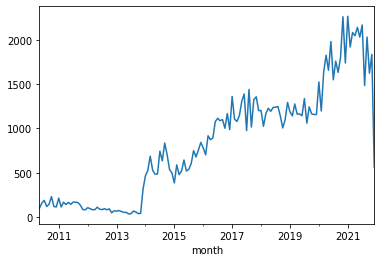

In [85]:
counts_monthly.plot.line()

etract relative change of counts over month

In [81]:
counts_monthly_change = counts_monthly.pct_change()

In [82]:
counts_monthly_change.head()

month
2010-05         NaN
2010-06    0.581227
2010-07    0.189498
2010-08   -0.366603
2010-09    0.215152
Freq: M, Name: hate_count, dtype: float64

<AxesSubplot:xlabel='month'>

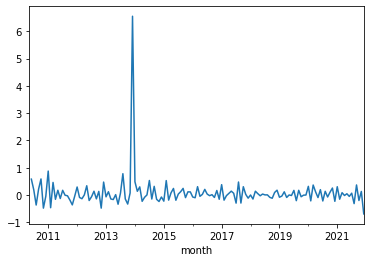

In [86]:
counts_monthly_change.plot.line()